## Calculate Sentiment returns and perform return analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from pandas.tseries.offsets import DateOffset
import edhec_risk_kit as erk

In [2]:
# Name control files as well as relevant columns to process data
out_col_S = ['Date','Ticker','TR_1M','Sentiment','S_Quintile']
control_S = pd.read_csv(r"C:\Users\B420615\OneDrive - Standard Bank\Py\Sentiment_Control.csv")
control_S = control_S['Files'].tolist()

In [ ]:
# create file of sentiment selection alpha scores for all periods and output
# Using improved append function that ensures proper date sorting and column matching
Sentiment_Score = erk.append_csv_files_by_date(
    file_list=control_S,
    file_path_template=r'C:\Users\B420615\OneDrive - Standard Bank\Neg_Sel\{}.csv',
    output_columns=out_col_S,
    date_column='Date',
    date_format='%Y%m%d'
)

In [4]:
Sentiment_Score.head()

,Date,Ticker,TR_1M,Sentiment,S_Quintile
0,2005-10-31,AU US Equity,-7.87,-0.069356,2
1,2005-10-31,EMI SJ Equity,3.09,0.310000,5
2,2005-10-31,CML SJ Equity,-0.91,0.248088,4
3,2005-10-31,ELH SJ Equity,-7.30,0.345633,5
4,2005-10-31,HYP SJ Equity,2.72,0.261420,5


In [5]:
#Create a column that aligns future 1M returns with current selection (Future_TR)
Sentiment_Score['Future_TR'] = Sentiment_Score.groupby('Ticker')['TR_1M'].shift(-1)
Sentiment_Score = Sentiment_Score.sort_values(by=['Date'])
Alltime = list(set(Sentiment_Score['Date'])) # used set to eliminate duplicate values
output_file_path = rf'C:\Users\B420615\OneDrive - Standard Bank\Neg_Sel\Sentiment_Score.csv'
Sentiment_Score.to_csv(output_file_path, index=False)

In [6]:
Sentiment_Score.head()

,Date,Ticker,TR_1M,Sentiment,S_Quintile,Future_TR
0,2005-10-31,AU US Equity,-7.87,-0.069356,2,5.35
78,2005-10-31,RLO SJ Equity,9.22,-0.090305,2,10.87
77,2005-10-31,DTC SJ Equity,-4.30,-0.002651,3,13.53
76,2005-10-31,SAB SJ Equity,0.80,0.251160,5,-5.31
75,2005-10-31,TKG SJ Equity,0.48,-0.149880,2,3.98


In [7]:
#Create a "liquid portfolio to eliminate illiquid stocks (defined by mkt cap). 
#Merge the liquidity filter dataframe and eliminate rows that do not meet liquidity requirements
liquidity_filter = 0.25
Jalsh_wts = pd.read_csv(rf'C:\Users\B420615\OneDrive - Standard Bank\Py\JalshWeightsBBG.csv')
Jalsh_wts["Date"] = pd.to_datetime(Jalsh_wts["Date"])
Jalsh_wts.rename(columns={'ID':'Ticker'},inplace=True)
Jalsh_wts.head()


Sentiment_Score_liquid = Sentiment_Score.merge(Jalsh_wts, on=['Date','Ticker'],how='left')
Sentiment_Score_liquid.drop(Sentiment_Score_liquid[Sentiment_Score_liquid['id().weights'] < liquidity_filter].index, inplace = True)


output_file_path = rf'C:\Users\B420615\OneDrive - Standard Bank\Neg_Sel\Sentiment_Score_liquid.csv'
Sentiment_Score.to_csv(output_file_path, index=False)



In [8]:
Sentiment_Score_liquid.tail()

,Date,Ticker,TR_1M,Sentiment,S_Quintile,Future_TR,id().weights,ID_BB_GLOBAL
28594,2025-10-31,CPI SJ Equity,11.04,0.029632,4,NaN,4.029672,BBG000D4HYB1
28597,2025-10-31,SBK SJ Equity,7.69,-0.100741,3,NaN,4.086289,BBG000BQR991
28599,2025-10-31,BVT SJ Equity,6.21,-0.226527,2,NaN,0.934154,BBG000BFBR74
28602,2025-10-31,KST SJ Equity,8.11,-0.067761,3,NaN,0.293262,BBG006MCB4L1
28603,2025-10-31,ABG SJ Equity,7.04,0.013533,4,NaN,1.963586,BBG000BF9DG8


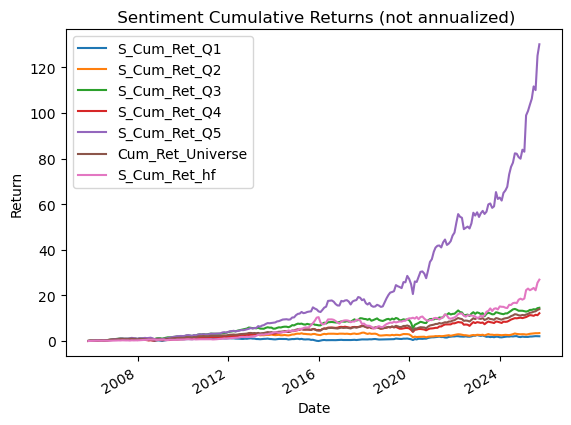

In [9]:
# Split data into quintiles, calculate quintile returns and graph quintile/universe performance - for Sentimentcomponent
averages = Sentiment_Score_liquid.groupby(['Date', 'S_Quintile'])['Future_TR'].mean().unstack(fill_value=0)
averages.reset_index(inplace=True)
averages.columns.name = None
averages.columns = ['Date','S_Q1','S_Q2','S_Q3','S_Q4','S_Q5']
Universe = Sentiment_Score_liquid.groupby(['Date'])['Future_TR'].mean()
averages = pd.merge(averages, Universe, on='Date', how='outer')
averages.rename(columns={'Future_TR':'Universe'},inplace=True)
averages['S_hf_returns'] = averages['S_Q5'] - averages['S_Q1']
averages['S_Cum_Ret_Q1'] = (1+averages['S_Q1']/100).cumprod()-1
averages['S_Cum_Ret_Q2'] = (1+averages['S_Q2']/100).cumprod()-1
averages['S_Cum_Ret_Q3'] = (1+averages['S_Q3']/100).cumprod()-1
averages['S_Cum_Ret_Q4'] = (1+averages['S_Q4']/100).cumprod()-1
averages['S_Cum_Ret_Q5'] = (1+averages['S_Q5']/100).cumprod()-1
averages['Cum_Ret_Universe'] = (1+averages['Universe']/100).cumprod()-1
averages['S_Cum_Ret_hf'] = ((1+averages['S_hf_returns']/100).cumprod()-1)

ax = averages.plot(xlabel='Date', ylabel='Return',x = 'Date',y = ['S_Cum_Ret_Q1','S_Cum_Ret_Q2','S_Cum_Ret_Q3','S_Cum_Ret_Q4','S_Cum_Ret_Q5','Cum_Ret_Universe','S_Cum_Ret_hf'])
ax.set_title(' Sentiment Cumulative Returns (not annualized)')

# Create a dataframe of average returns to be used to calculate the IC score
Ave_returns = averages[['Date', 'Universe']].copy()
# Create output file
output_file_path = rf'C:\Users\B420615\OneDrive - Standard Bank\Neg_Sel\Sentiment_Q_Scores_liquid.csv'
averages.to_csv(output_file_path, index=False)

In [10]:
Universe = Universe.to_frame(name='Universe_ret')
Universe.head()

,Universe_ret
Date,
2005-10-31,4.986226
2005-11-30,8.604906
2005-12-31,0.361400
2006-01-31,0.503286
2006-02-28,6.999608


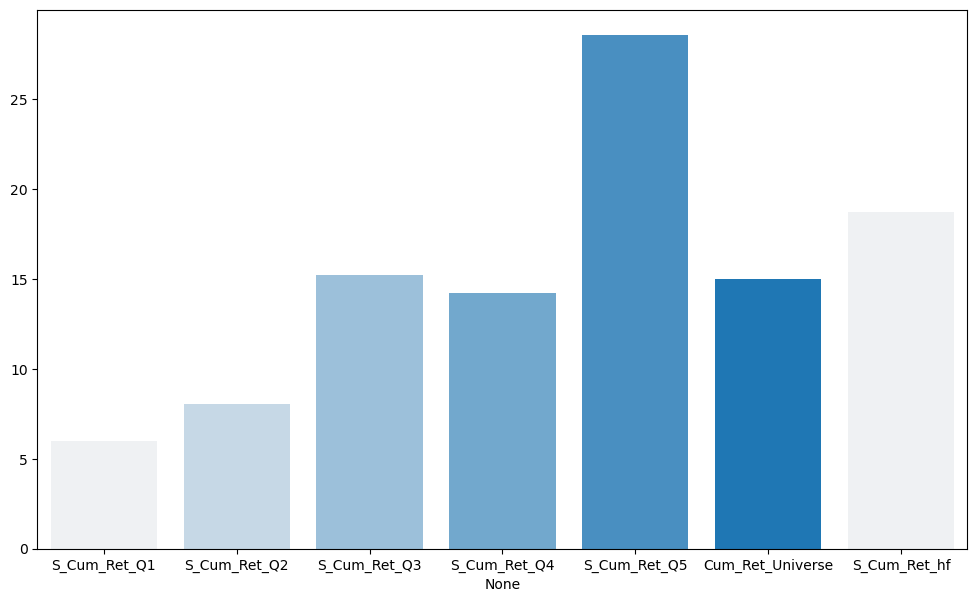

In [11]:
#Show annualised returns
last_row_series = ((1+(averages.iloc[-2][['S_Cum_Ret_Q1','S_Cum_Ret_Q2','S_Cum_Ret_Q3','S_Cum_Ret_Q4',
                                         'S_Cum_Ret_Q5','Cum_Ret_Universe','S_Cum_Ret_hf']]))**(12/233)-1)*100
last_row_series
fig,ax = plt.subplots(figsize = (12,7))
returns = sns.barplot(
    x=last_row_series.index,  # Use the index (the column names) as the x-axis labels
    y=last_row_series.values, # Use the values (the calculated returns) as the bar heights
    color=(sns.light_palette(sns.color_palette()[0])),
    saturation=50.
)

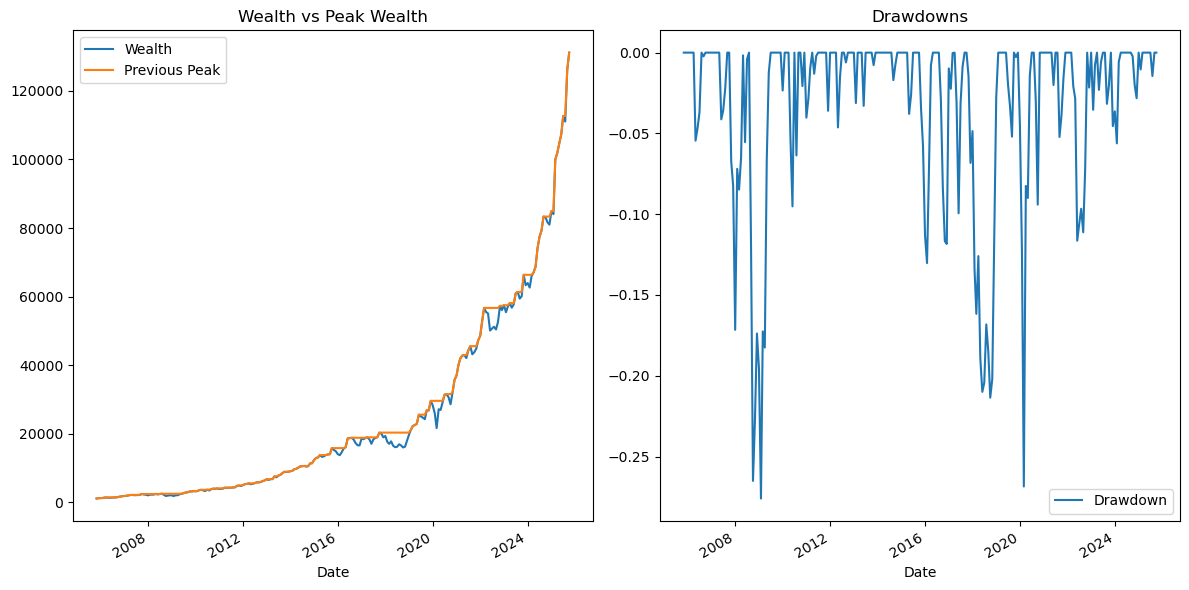

In [12]:
#Calculate drawdowns
Drawdowns = erk.drawdown(averages['S_Q5']/100)
Drawdowns = pd.merge(Drawdowns, averages['Date'], left_index=True,right_index=True)
Drawdowns = Drawdowns.reindex(['Date', 'Wealth', 'Previous Peak','Drawdown'], axis=1)
Drawdowns

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
Drawdowns.plot(x='Date',y=['Wealth','Previous Peak'],ax=axes[0])
axes[0].set_title('Wealth vs Peak Wealth')

Drawdowns.plot(x='Date',y='Drawdown',ax=axes[1])
axes[1].set_title('Drawdowns')

plt.tight_layout()
plt.show()
                  
#ax = Drawdowns.plot(xlabel='Months', ylabel='Wealth',x='Date',y = ['Wealth','Previous Peak'])
#ax.set_title('Wealth vs Peak Wealth')


In [13]:
# Sharpe Ratio
erk.sharpe_ratio(averages['S_Q5']/100, 0, 12)

np.float64(1.4204698603224684)

In [15]:
#Isolate the long portfolio through time - output 'Longs' file
filtered_df = pd.DataFrame()
for date in Alltime:
    #Filter rows for the date and specified integer value
    temp_df = Sentiment_Score_liquid[(Sentiment_Score_liquid['Date'] == date) & (Sentiment_Score_liquid['S_Quintile'] == 5) ]
    filtered_df = pd.concat([filtered_df, temp_df], ignore_index=True)
    filtered_df = filtered_df.sort_values(by=['Date'])

output_file_path = rf'C:\Users\B420615\OneDrive - Standard Bank\Neg_Sel\Longs_liquid.csv'
filtered_df.to_csv(output_file_path, index=False)

In [33]:
# Universe_returns has columns: ['Date', 'Universe_Return']

# Step 1: Merge universe returns with your main dataframe
df_merged = Sentiment_Score_liquid.merge(Universe, on='Date', how='left')

# Step 2: Filter for 5th quintile only
q5_df = df_merged[df_merged['S_Quintile'] == 5].copy()

# Step 3: Create a column to check if stock beat universe
q5_df['Beat_Universe'] = (q5_df['Future_TR'] > q5_df['Universe_ret']).astype(int)

# Step 4: Calculate monthly IC (hit rate)
monthly_hits = q5_df.groupby('Date').agg({
    'Beat_Universe': ['sum', 'count']
})

# Step 4: Calculate monthly IC (hit rate)
monthly_hits = q5_df.groupby('Date').agg({
    'Beat_Universe': ['sum', 'count']
})
monthly_hits.columns = ['Beats', 'Total_Stocks']
monthly_hits['Monthly_IC'] = (2*monthly_hits['Beats'] / monthly_hits['Total_Stocks'])-1

# Step 5: Calculate cumulative IC
monthly_hits['Cumulative_IC'] = monthly_hits['Monthly_IC'].cumsum()

# Reset index to make Date a column
monthly_hits = monthly_hits.reset_index()

Overall_ic = monthly_hits[0:-2]['Monthly_IC'].mean(axis=0)
monthly_hits['ic_12M'] = monthly_hits['Monthly_IC'].rolling(window=12, min_periods=12).mean()

Overall_ic

np.float64(0.04063483202138664)

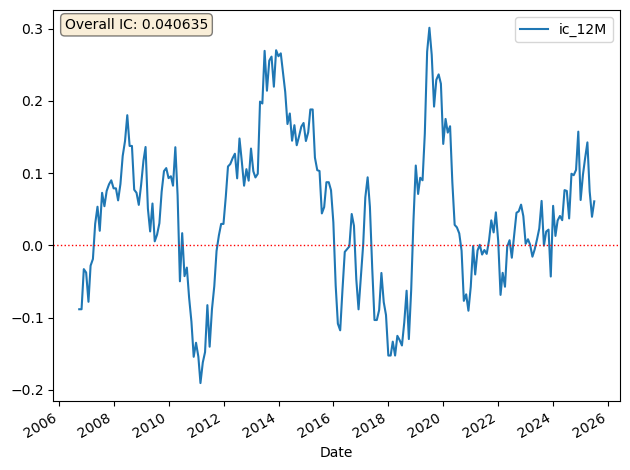

In [34]:
monthly_hits.loc[0:235].plot(x='Date',y=['ic_12M'])
plt.axhline(y=0, color='red', linestyle=':', linewidth=1)

plt.text(0.02, 0.98, f'Overall IC: {Overall_ic:.5}', 
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()